# Tree Census Final Project

## Packages

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support, make_scorer, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,classification_report
import warnings
warnings.filterwarnings('ignore')

## Preprocessing

In [70]:
# load in data with relative path
tree_df = pd.read_csv('sample_data/2015_Street_Tree_Census_-_Tree_Data.csv')

In [71]:
# drop columns that arent useful, or suffer from multicolinearity
tree_df = tree_df.drop(columns=[
    'borocode', 'x_sp', 'y_sp', 'state', 'nta_name', 'zip_city', 'address',
    'spc_latin', 'created_at', 'tree_id', 'block_id', 'user_type', 'bin',
    'bbl', 'council district', 'boro_ct', 'census tract', 'problems', 'status',
    'stump_diam', 'postcode', 'community board', 'cncldist', 'st_assem', 'st_senate', 
    'nta', 'spc_common'
])

In [72]:
# drop NA and dead tree values
tree_df = tree_df[tree_df['health'].notna()]
tree_df = tree_df.dropna(how='any')

In [73]:
# scale diameters (only continuos numerical feature left)
scaler = StandardScaler()
tree_df['tree_dbh'] = scaler.fit_transform(tree_df[['tree_dbh']])

In [74]:
# Ordinal Encode (categorical hierarchal features)
health = ['Poor', 'Fair', 'Good']
enc = OrdinalEncoder(categories=[health])
tree_df['health'] = enc.fit_transform(tree_df[['health']])

steward = ['None', '1or2', '3or4', '4orMore']
enc = OrdinalEncoder(categories=[steward])
tree_df['steward'] = enc.fit_transform(tree_df[['steward']])

sidewalk = ['NoDamage', 'Damage']
enc = OrdinalEncoder(categories=[sidewalk])
tree_df['sidewalk'] = enc.fit_transform(tree_df[['sidewalk']])

curbloc = ['OnCurb', 'OffsetFromCurb']
enc = OrdinalEncoder(categories=[curbloc])
tree_df['curb_loc'] = enc.fit_transform(tree_df[['curb_loc']])

yes_no = ['No', 'Yes']
enc = OrdinalEncoder(categories=[yes_no])

yes_no_features = [
    'brch_other', 'brch_shoe', 'brch_light', 'trnk_other', 'trnk_light',
    'trunk_wire', 'root_other', 'root_grate', 'root_stone'
]

for feat in yes_no_features:
    tree_df[feat] = enc.fit_transform(tree_df[[feat]])
    
# One Hot Encode (non-hierarchal categorical features)
enc = OneHotEncoder()
guards = enc.fit_transform(tree_df[['guards']])
tree_df['guards_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['guards'])

guards = enc.fit_transform(tree_df[['borough']])
tree_df['borough_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['borough'])

In [75]:
# split to x and y sets
y = np.asarray(tree_df['health'])
x = tree_df.drop(columns=['health'])

In [76]:
# random sample (stratified) for dev, test, train and val
x_dev, x_test, y_dev, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify = y)
x_train, x_val, y_train, y_val = train_test_split(x_dev, y_dev, test_size=0.2, random_state=42, stratify = y_dev)

In [77]:
# over-sampling of training data
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(x_train, y_train)

In [78]:
# under sampling of training data
rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(x_train, y_train)

In [79]:
# smote sampling of training data
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x_train, y_train)

## Decision Tree

In [80]:
# function to evaluate the model

def model_result(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    # confusion_matrix
    cf = confusion_matrix(y_test, model.predict(x_test))
    sns.heatmap(cf, annot = True, fmt = 'g')
    plt.show()
    # result plot
    print(classification_report(y_test, model.predict(x_test)))

In [81]:
# function to fit and tune the model
def dt_select(x_train,y_train,score):
    # possible values for the model to be tuned on
    param_grid = {
        'max_depth': [4,8,10,12,15,20],
        'min_samples_split': np.linspace(0.1, 0.3, 3, endpoint=True),
        "max_features":["log2","sqrt",None],
        "max_leaf_nodes": [None,10,20,30],
        'ccp_alpha' : np.logspace(-6, -4, 3)
    }
    
    # create a base model
    dt = DecisionTreeClassifier(random_state=100)

    # initantiate the random search model based on parameters defined above
    randomized_search = RandomizedSearchCV(estimator = dt, param_distributions = param_grid, scoring=score,cv=5,random_state=100)

    randomized_model=randomized_search.fit(x_train,y_train)
    return randomized_model

In [97]:

#plot feature importance

def feature_importance(x_train, model):
  features = x_train.columns.values
  plt.figure(figsize = (12, 6))
  feat_imps = zip(features, model.best_estimator_.feature_importances_)
  feats,imps = zip(*(sorted(list(filter(lambda x: x[1] != 0 , feat_imps)), key=lambda x: x[1], reverse=True)))
  ax = sns.barplot(x = list(feats), y = list(imps))
  ax.tick_params(axis = 'x', rotation = 90)

# random stratified sampling

optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 12, 'ccp_alpha': 1e-06}
optimal score 0.8109073571767318
test score 0.8109081987825261


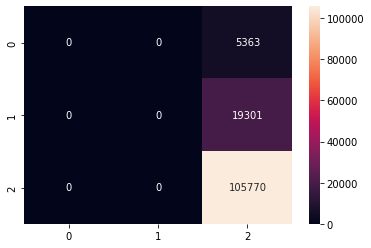

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.00      0.00      0.00     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.27      0.33      0.30    130434
weighted avg       0.66      0.81      0.73    130434



In [82]:

# accuracy as scoring metric
random_best = dt_select(x_train,y_train,'accuracy')
print("optimal hyperparameters",random_best.best_params_)
print("optimal score", random_best.best_score_)
print("test score",random_best.score(x_test,y_test))

#recall as metric for hyperparamter tuning
model_result(random_best, x_train, y_train, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 12, 'ccp_alpha': 1e-06}
optimal score 0.3333333333333333
test score 0.3333333333333333


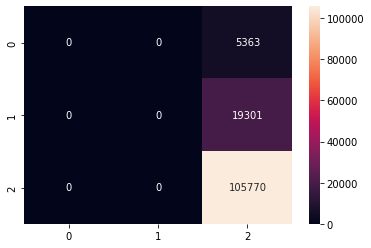

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.00      0.00      0.00     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.27      0.33      0.30    130434
weighted avg       0.66      0.81      0.73    130434



In [83]:
# random stratified sampling
# recall as scoring metric
random_best = dt_select(x_train,y_train,'recall_macro')
print("optimal hyperparameters",random_best.best_params_)
print("optimal score", random_best.best_score_)
print("test score",random_best.score(x_test,y_test))

#recall as metric for hyperparamter tuning
model_result(random_best, x_train, y_train, x_test, y_test)



optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 12, 'ccp_alpha': 1e-06}
optimal f1 score 0.29852709065529426
test f1 score 0.2985272617454969


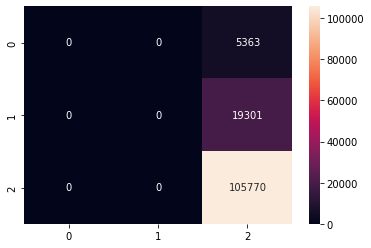

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5363
         1.0       0.00      0.00      0.00     19301
         2.0       0.81      1.00      0.90    105770

    accuracy                           0.81    130434
   macro avg       0.27      0.33      0.30    130434
weighted avg       0.66      0.81      0.73    130434



In [84]:
#f1 as scoring metric
random_best = dt_select(x_train,y_train,'f1_macro')
print("optimal hyperparameters",random_best.best_params_)
print("optimal f1 score", random_best.best_score_)
print("test f1 score",random_best.score(x_test,y_test))
#f1 as metric for hyperparamter tuning
model_result(random_best, x_train, y_train, x_test, y_test)

# random over sampling

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal score 0.42521139435335636
test score 0.4216232268146592


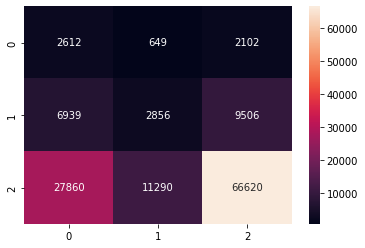

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.19      0.15      0.17     19301
         2.0       0.85      0.63      0.72    105770

    accuracy                           0.55    130434
   macro avg       0.37      0.42      0.34    130434
weighted avg       0.72      0.55      0.62    130434



In [85]:

# recall as scoring metric
over_best_recall = dt_select(x_ros, y_ros,'recall_macro')
print("optimal hyperparameters",over_best_recall.best_params_)
print("optimal score", over_best_recall.best_score_)
print("test score",over_best_recall.score(x_test,y_test))

# recallmacro as metric for hyperparamter tuning
model_result(over_best_recall, x_ros, y_ros, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal accuracy score 0.4252114213595847
test accuracy 0.552677982734563


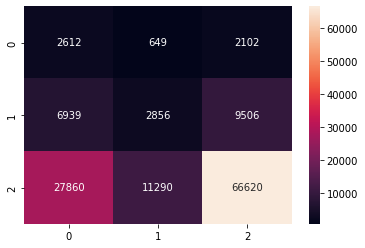

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.19      0.15      0.17     19301
         2.0       0.85      0.63      0.72    105770

    accuracy                           0.55    130434
   macro avg       0.37      0.42      0.34    130434
weighted avg       0.72      0.55      0.62    130434



In [86]:
# accuracy as score metric
over_best_acc = dt_select(x_ros, y_ros,'accuracy')
print("optimal hyperparameters",over_best_acc.best_params_)
print("optimal accuracy score", over_best_acc.best_score_)
print("test accuracy",over_best_acc.score(x_test,y_test))

# as metric for hyperparamter tuning
model_result(over_best_acc, x_ros, y_ros, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.2, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 12, 'ccp_alpha': 1e-06}
optimal f1 score 0.40025096917702496
test f1 score 0.3201379887339995


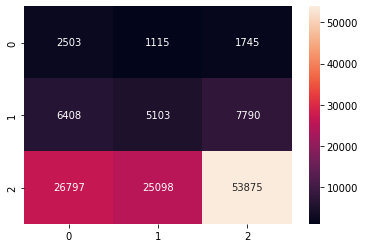

              precision    recall  f1-score   support

         0.0       0.07      0.47      0.12      5363
         1.0       0.16      0.26      0.20     19301
         2.0       0.85      0.51      0.64    105770

    accuracy                           0.47    130434
   macro avg       0.36      0.41      0.32    130434
weighted avg       0.72      0.47      0.55    130434



In [87]:
# f1 as score metric
over_best_f1 = dt_select(x_ros, y_ros,'f1_macro')
print("optimal hyperparameters",over_best_f1.best_params_)
print("optimal f1 score", over_best_f1.best_score_)
print("test f1 score",over_best_f1.score(x_test,y_test))

#f1 as metric for hyperparamter tuning
model_result(over_best_f1, x_ros, y_ros, x_test, y_test)

# random under sampling

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal accuracy score 0.42282814886132025
test accuracy score 0.5130334115338026


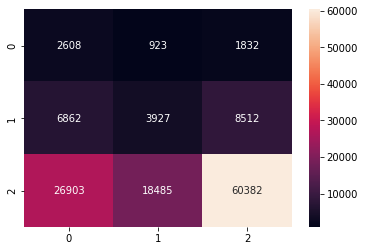

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.17      0.20      0.18     19301
         2.0       0.85      0.57      0.68    105770

    accuracy                           0.51    130434
   macro avg       0.36      0.42      0.33    130434
weighted avg       0.72      0.51      0.59    130434



In [88]:
# random under sampling
# accuracy as scoring metric

under_best_acc = dt_select(x_rus, y_rus,'accuracy')
print("optimal hyperparameters",under_best_acc.best_params_)
print("optimal accuracy score", under_best_acc.best_score_)
print("test accuracy score",under_best_acc.score(x_test,y_test))
# accuracy as metric for hyperparamter pruning
model_result(under_best_acc, x_rus, y_rus, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal recall score 0.4228293714894356
test recall score 0.4202120521676436


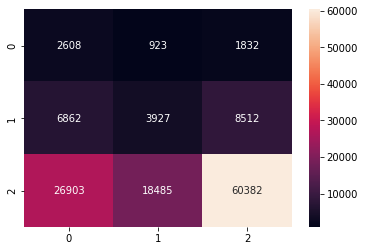

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.17      0.20      0.18     19301
         2.0       0.85      0.57      0.68    105770

    accuracy                           0.51    130434
   macro avg       0.36      0.42      0.33    130434
weighted avg       0.72      0.51      0.59    130434



In [89]:

# recall as scoring metric
under_best_recall = dt_select(x_rus, y_rus,'recall_macro')
print("optimal hyperparameters",under_best_recall.best_params_)
print("optimal recall score", under_best_recall.best_score_)
print("test recall score",under_best_recall.score(x_test,y_test))

# recall as metric for hyperparamter tuning
model_result(under_best_recall, x_rus, y_rus, x_test, y_test)



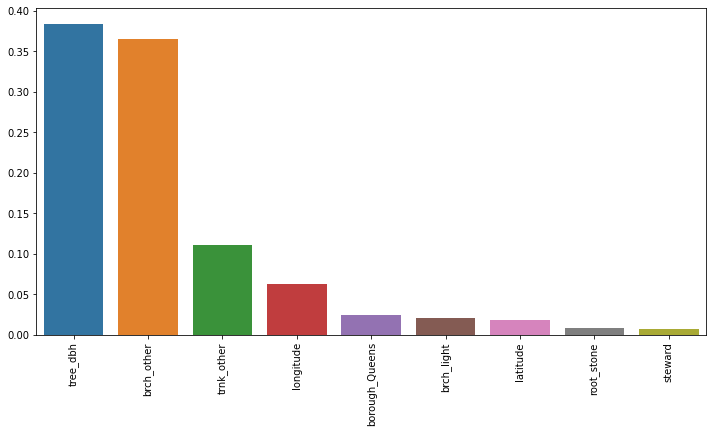

In [98]:
feature_importance(x_rus, under_best_recall)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal f1 score 0.4097896911316369
test f1 score 0.3311391234276632


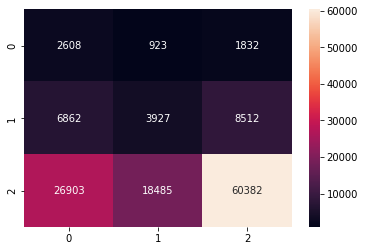

              precision    recall  f1-score   support

         0.0       0.07      0.49      0.12      5363
         1.0       0.17      0.20      0.18     19301
         2.0       0.85      0.57      0.68    105770

    accuracy                           0.51    130434
   macro avg       0.36      0.42      0.33    130434
weighted avg       0.72      0.51      0.59    130434



In [90]:
# f1 as score metric
under_best_f1 = dt_select(x_rus, y_rus,'f1_macro')
print("optimal hyperparameters",under_best_f1.best_params_)
print("optimal f1 score", under_best_f1.best_score_)
print("test f1 score",under_best_f1.score(x_test,y_test))
# f1 as metric for hyperparamter pruning
model_result(under_best_f1, x_rus, y_rus, x_test, y_test)

# smote sampling

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal recall score 0.42784390717769993
test recall score 0.41559624496818587


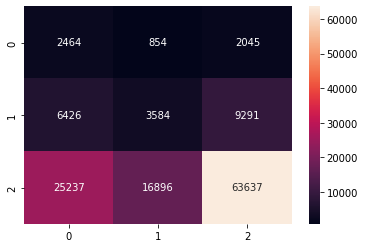

              precision    recall  f1-score   support

         0.0       0.07      0.46      0.12      5363
         1.0       0.17      0.19      0.18     19301
         2.0       0.85      0.60      0.70    105770

    accuracy                           0.53    130434
   macro avg       0.36      0.42      0.34    130434
weighted avg       0.72      0.53      0.60    130434



In [91]:

# recall as metric
smote_best = dt_select(x_smote, y_smote,"recall_macro")
print("optimal hyperparameters",smote_best.best_params_)
print("optimal recall score", smote_best.best_score_)
print("test recall score",smote_best.score(x_test,y_test))

#recall as metric for hyperparamter pruning
model_result(smote_best, x_smote, y_smote, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal score 0.427843910192804
test score 0.5342548721958998


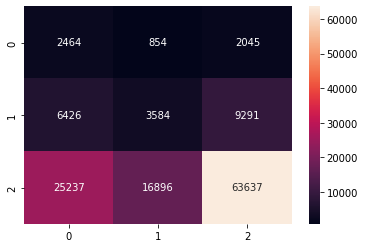

              precision    recall  f1-score   support

         0.0       0.07      0.46      0.12      5363
         1.0       0.17      0.19      0.18     19301
         2.0       0.85      0.60      0.70    105770

    accuracy                           0.53    130434
   macro avg       0.36      0.42      0.34    130434
weighted avg       0.72      0.53      0.60    130434



In [92]:
# accuracy as metric
smote_best_acc = dt_select(x_smote, y_smote,"accuracy")
print("optimal hyperparameters",smote_best_acc.best_params_)
print("optimal score", smote_best_acc.best_score_)
print("test score",smote_best_acc.score(x_test,y_test))

#accuracy as metric for hyperparamter pruning
model_result(smote_best_acc, x_smote, y_smote, x_test, y_test)

optimal hyperparameters {'min_samples_split': 0.1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'ccp_alpha': 1e-05}
optimal f1 score 0.4084079737595042
test f1 score 0.33512061923807873


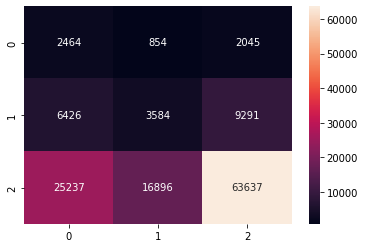

              precision    recall  f1-score   support

         0.0       0.07      0.46      0.12      5363
         1.0       0.17      0.19      0.18     19301
         2.0       0.85      0.60      0.70    105770

    accuracy                           0.53    130434
   macro avg       0.36      0.42      0.34    130434
weighted avg       0.72      0.53      0.60    130434



In [93]:
# f1 sccore as metric
smote_best_f1 = dt_select(x_smote, y_smote,'f1_macro')
print("optimal hyperparameters",smote_best_f1.best_params_)
print("optimal f1 score", smote_best_f1.best_score_)
print("test f1 score",smote_best_f1.score(x_test,y_test))
# f1 as metric for hyperparamter pruning
model_result(smote_best_f1, x_smote, y_smote, x_test, y_test)



overall, recall as a scoring metric for tunning is best for predicting bad and fair trees well.

under sampling is best in having highest recall in poor and fair trees, which means have highest rate in predicting correct poor and fair trees.